# Classification CAH

In this notebook, the data with 100000 flights is used to conduct the classification.

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.ensemble import GradientBoostingClassifier


In [64]:
%run pretreatment.py
%run ../flight\ phase\ on\ dataset/db.py

database_name = 'descriptors_1.db'

columns_dropped = ['icao', 'icao_airline', 'duration_cruise', 'airport_climb', 'airport_descent']

df, df_meteo, df_operation, airlines_decoder = pretreatment(database_name, columns_dropped, threshold_nb_flights=100, drop_min_max=True)
columns = df.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df, n_estimators=100)
columns_remained = feature_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns, begin=-3, end=3, n_choices=10)

number of evaluation is 1
number of evaluation is 2


In [65]:
columns_meteo = df_meteo.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df_meteo, n_estimators=100)
columns_remained_meteo = feature_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns_meteo, begin=-3, end=3, n_choices=10)

number of evaluation is 1


In [66]:
columns_operation = df_operation.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df_operation, n_estimators=100)
columns_remained_operation = feature_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns_operation, begin=-3, end=3, n_choices=10)

number of evaluation is 1


In [67]:
%run pretreatment.py
print(f'Columns deleted for whole dataset: {columns_deleted(columns, columns_remained)}')
print(f'Columns deleted for meteo sub dataset: {columns_deleted(columns_meteo, columns_remained_meteo)}')
print(f'Columns deleted for meteo sub dataset: {columns_deleted(columns_operation, columns_remained_operation)}')

Columns deleted for whole dataset: ['wind_spind_kt_climb']
Columns deleted for meteo sub dataset: ['wind_spind_kt_descent', 'wind_spind_kt_climb']
Columns deleted for meteo sub dataset: ['avg_vertrate_speed_cruise']


In [68]:
X = df.iloc[:,:-1]
y = df.loc[:,["airline_cat"]]

In [69]:
X_selected = X[columns_remained]

# Aggregating data

In [70]:
selected_df = pd.merge(X_selected, y, how = 'left', left_index = True, right_index = True)

In [72]:
df_median = selected_df.groupby(by = 'airline_cat').median()

In [73]:
df_median.dropna(inplace=True)

In [74]:
df_median.columns

Index(['duration_descent', 'avg_speed_descent', 'std_speed_descent',
       'avg_vertrate_speed_descent', 'std_vertrate_speed_descent',
       'temp_c_descent', 'dewpoint_c_descent', 'wind_spind_kt_descent',
       'avg_speed_cruise', 'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'mean_altitude_cruise',
       'std_altitude_cruise', 'duration_climb', 'avg_speed_climb',
       'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'temp_c_climb', 'dewpoint_c_climb'],
      dtype='object')

In [77]:
df_median_values = df_median.values
scaler = MaxAbsScaler().fit(df_median_values)
df_median_scaled = scaler.fit_transform(df_median_values)
df_median_scaled = pd.DataFrame(df_median_scaled)

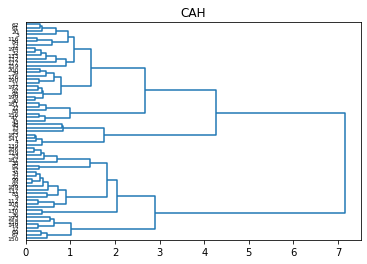

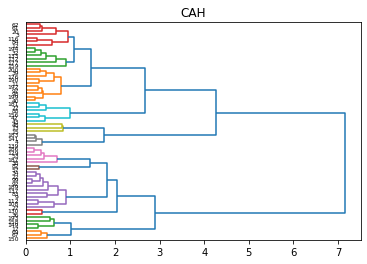

In [80]:
Z = linkage(df_median_scaled,method='ward',metric='euclidean')
threshold = 1
plt.title("CAH")
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=0)
plt.show()
plt.title('CAH')
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=threshold)
plt.savefig('cah.svg')

In [79]:
import numpy as np
import pandas
groupes_cah = fcluster(Z,t=threshold,criterion='distance')
print(groupes_cah)

[12  7  4 10 12  8  8  2 12  4  4 11  4  3  6 10 10  9  9  8  6  5 12 12
  1  1  9  5  4 12  9  4 10 10  4  4  4 12  6  3 11 11  4  7  7  2  1  9
  2 11 10 11  9  7  6  6  4 10 10  2 11 10 10]


In [82]:
idg = np.argsort(groupes_cah)
df1 = pandas.DataFrame(df_median.index[idg],groupes_cah[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')

In [83]:
classif = pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

In [84]:
df_median['group'] = groupes_cah
df_median_scaled['group'] = groupes_cah
feature_diff = df_median_scaled.groupby('group').median().std()

In [85]:
idx = feature_diff.sort_values(ascending=False).index

In [86]:
columns_sorted = np.take(np.array(columns_remained),idx)

In [91]:
# sort the result by the importance of features
importance_column = df_median.groupby('group').median().loc[:,columns_sorted]
with open('classification_stats_importance.csv', 'w') as f:
    f.write(importance_column.to_csv())

In [92]:
pandas.set_option('display.max_rows', 63)
with open('classification.csv','w') as f:
    f.write(classif.to_csv())